# Data Preprocessing
We need to filter and feature-select data to provide consistent inputs to dimensionality reduction methods.

In [1]:
import sys
sys.path.append('../')
from fcc_DRs import *
%matplotlib inline

Using TensorFlow backend.
/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/kopt/config.py:60: YAMLLoadWarning: 
  *** Calling yaml.load() without Loader=... is deprecated.
  *** The default Loader is unsafe.
  *** Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


In [182]:
# reload functions when editing file
del sys.modules['fcc_DRs']
from fcc_DRs import *

---
To benchmark dimensionality reduction techniques, we are using two datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse colon scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be highly __discrete__, containing highly separable cell populations, where the latter should be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
In this notebook, we will read in the counts for each of these datasets, _select gene features_ to limit input size to dimensionality reduction methods, and _downsample to a common cell number_ for ease of comparison.

---
#### 0.0 read in discrete dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30

In [2]:
retina = RNA_counts.from_file('../inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz', cells_axis=1, labels=[0,0])

In [3]:
# see how many cells and genes are present in whole counts matrix
retina.data.shape

(6600, 20478)

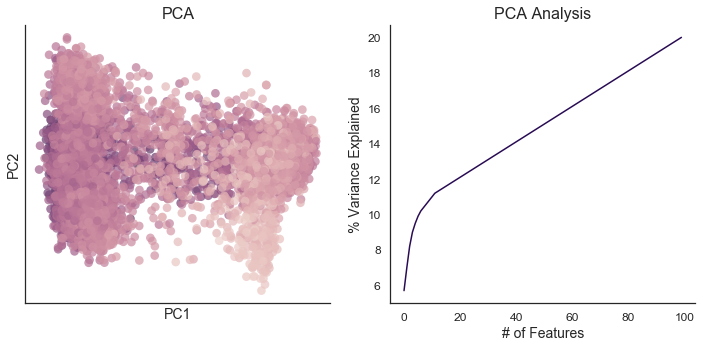

In [87]:
# arcsinh-normalize fractional counts for all 20k+ genes, and perform 100 component PCA
retina_PCA100 = fcc_PCA(retina.arcsinh_norm(norm='l1'), n_components=100)
retina_PCA100.plot_PCA()

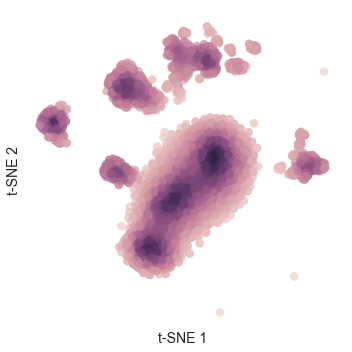

CPU times: user 1min, sys: 1.03 s, total: 1min 1s
Wall time: 1min 1s


In [5]:
%%time 
# now perform standard t-SNE (perplexity 30) and show results
retina_tSNE = fcc_tSNE(retina_PCA100.results, perplexity=30, seed=18)
retina_tSNE.plot()

---
#### 0.1 assign clusters
* density-peak clustering of whole-dataset t-SNE

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x137a580b8>)

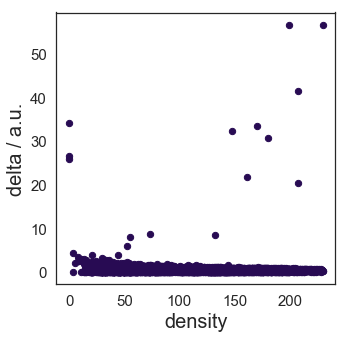

In [88]:
# show potential density-peak cluster centers
retina_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13cae93c8>)

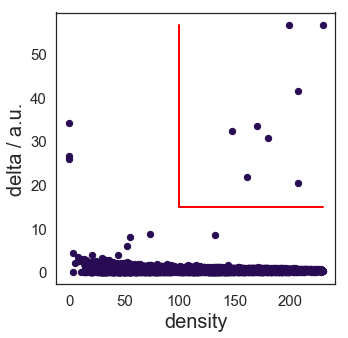

In [89]:
# assign cluster center cutoffs and show decision graph again
retina_tSNE.clu.assign(100,15)
retina_tSNE.clu.draw_decision_graph(min_delta=retina_tSNE.clu.min_delta, 
                                    min_density=retina_tSNE.clu.min_density)

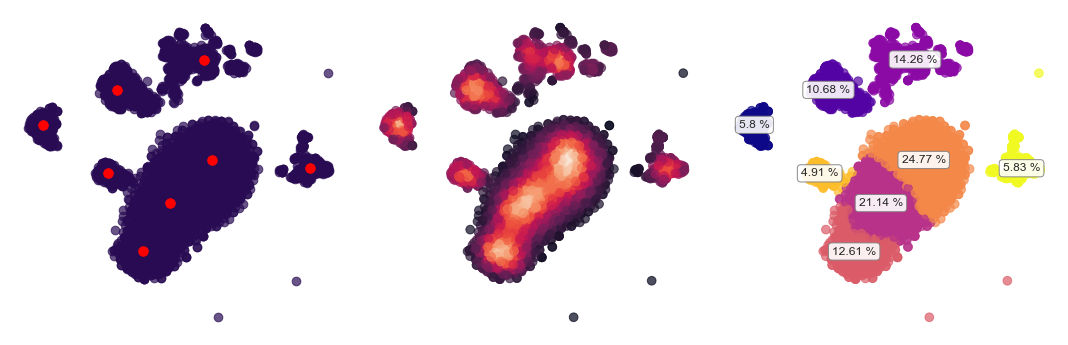

In [90]:
retina_tSNE.plot_clusters() # visualize clustering

In [91]:
retina_tSNE.cluster_counts()

383 cells in cluster 0 (5.803 %)

705 cells in cluster 1 (10.682 %)

941 cells in cluster 2 (14.258 %)

1395 cells in cluster 3 (21.136 %)

832 cells in cluster 4 (12.606 %)

1635 cells in cluster 5 (24.773 %)

324 cells in cluster 6 (4.909 %)

385 cells in cluster 7 (5.833 %)



In [92]:
print('Silhouette Score: {}\n'.format(retina_tSNE.silhouette_score()))

Silhouette Score: 0.5314646363258362



---
#### 0.2 filter genes and cells to manageable size
* _select variable genes_ to reduce dimension
* _downsample cells_ for future processing, maintaining cluster proportions

In [11]:
# select 500 most variable genes
retina_varselect = RNA_counts.var_select(retina, n_features=500) 

In [14]:
# choose 1600 cells with proportional representation from clusters above
retina_0 = RNA_counts.downsample_proportional(retina_varselect, retina_tSNE.clu.membership, n_cells=1600, seed=18)

In [15]:
# ensure there are no genes or cells with zero counts for the whole resulting matrix
print('minimum counts per cell: {}\nminimum counts per gene: {}'.format(retina_0.data.sum(axis=1).min(), retina_0.data.sum(axis=0).min()))

minimum counts per cell: 132
minimum counts per gene: 3


Now, we can re-visualize as before to make sure we have a representative subset of the data:

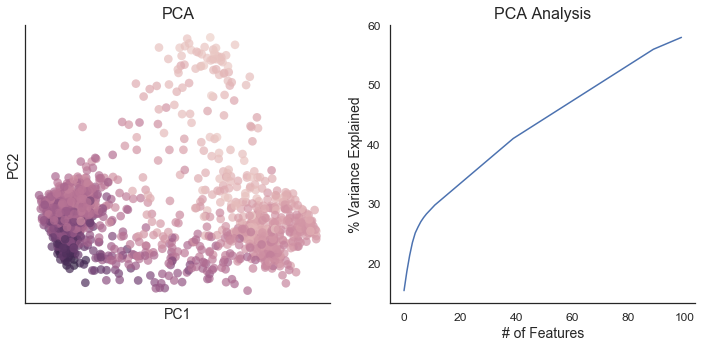

CPU times: user 1.25 s, sys: 126 ms, total: 1.38 s
Wall time: 1e+03 ms


In [184]:
%%time
retina_0_PCA100 = fcc_PCA(matrix=retina_0.arcsinh_norm(), n_components=100)
retina_0_PCA100.plot_PCA()

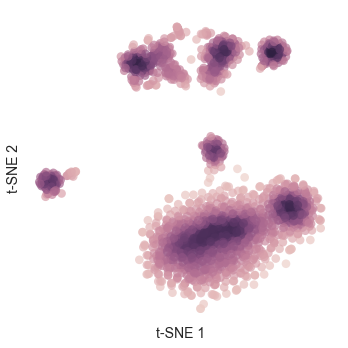

CPU times: user 9.68 s, sys: 81.5 ms, total: 9.76 s
Wall time: 9.76 s


In [183]:
%%time
retina_0_tSNE = fcc_tSNE(retina_0_PCA100.results, perplexity=30, seed=18)
retina_0_tSNE.plot()

Print out some cell type markers for cluster identification:

In [132]:
retina_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Opn1mw$')].flatten(), save_to='retina_Opn1mw.png')

In [138]:
retina_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Rlbp1$')].flatten(), save_to='retina_Rlbp1.png')

In [142]:
retina_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Vsx2$')].flatten(), save_to='retina_Vsx2.png')

In [148]:
retina_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Pax6$')].flatten(), save_to='retina_Pax6.png')

---
#### 0.3 write results to file

In [19]:
retina_0.data.to_csv('../inputs/GSM1626793_P14Retina_1.processed.tsv', sep='\t', header=True, index=True)

In [21]:
retina_0.data.to_csv('../inputs/GSM1626793_P14Retina_1.processed.norowlabels.tsv', sep='\t', header=True, index=False)

---
#### 1.0 read in continuous dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30

In [18]:
colon = RNA_counts.from_file(datafile='../inputs/GSM2743164_rep1_colon_rnaseq.csv.gz', cells_axis=1, labels=[0,0])

In [19]:
# see how many cells and genes are present in whole counts matrix
colon.data.shape

(1738, 25504)

In [33]:
colon.counts[:,colon.gene_IDs=='Cd8a'].flatten()

array([0, 0, 0, ..., 0, 0, 0])

This cell number is already what we want.  Let's just select the 500 most variable genes and visualize the dataset.

---
#### 1.1 filter genes to manageable size
* _select variable genes_ to reduce dimension

In [27]:
# select 500 most variable genes
colon_0 = RNA_counts.var_select(colon, n_features=500) 

In [28]:
# ensure there are no genes or cells with zero counts for the whole resulting matrix
print('minimum counts per cell: {}\nminimum counts per gene: {}'.format(colon_0.data.sum(axis=1).min(), colon_0.data.sum(axis=0).min()))

minimum counts per cell: 307
minimum counts per gene: 249


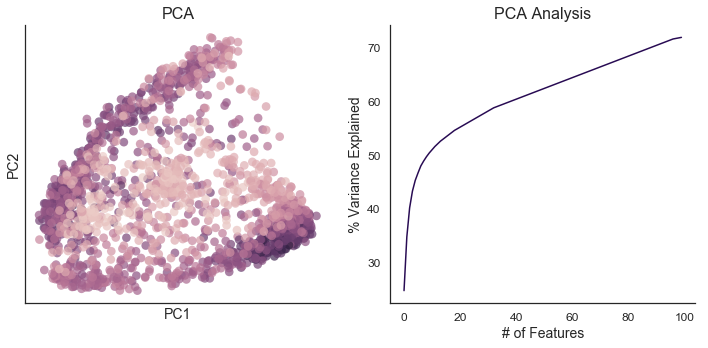

CPU times: user 1.22 s, sys: 131 ms, total: 1.35 s
Wall time: 846 ms


In [95]:
%%time
colon_0_PCA100 = fcc_PCA(matrix=colon_0.arcsinh_norm(), n_components=100)
colon_0_PCA100.plot_PCA()

In [96]:
%%time
colon_0_tSNE = fcc_tSNE(colon_0_PCA100.results, perplexity=30, seed=18)

CPU times: user 10.4 s, sys: 70.1 ms, total: 10.5 s
Wall time: 10.5 s


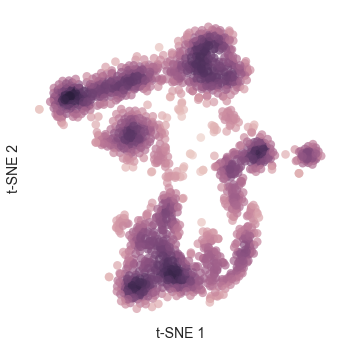

In [159]:
colon_0_tSNE.plot()

Print out some cell type markers for cluster identification:

In [152]:
colon_0_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Krt8'].flatten(), save_to='colon_Krt8.png')

In [154]:
colon_0_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Cd8a'].flatten(), save_to='colon_Cd8a.png')

In [156]:
colon_0_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Muc2'].flatten(), save_to='colon_Muc2.png')

In [158]:
colon_0_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Krt20'].flatten(), save_to='colon_Krt20.png')

In [161]:
colon_0_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Reg4'].flatten(), save_to='colon_Reg4.png')

---
#### 1.2 write results to file

In [24]:
colon_0.data.to_csv('../inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', sep='\t', header=True, index=True)

In [25]:
colon_0.data.to_csv('../inputs/GSM2743164_rep1_colon_rnaseq.processed.norowlabels.tsv', sep='\t', header=True, index=False)